In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from matplotlib import pyplot as plt
#from models import EEGNet

In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0],True)

In [3]:
data = pd.read_csv('dataset/preprocessed/reshaped_pca98_df')
label = pd.read_csv('dataset/preprocessed/label')

In [4]:
X = np.array(data)
Y = np.array(label)

In [5]:
X = X[:, 1:]
Y = Y[:, 1:]

In [6]:
#Y = np.append(Y,Y, axis=0)

In [7]:
X.shape

(2076, 1603)

In [8]:
n_split = 10
input_dim = len(X)
stdv = np.std(X)

In [9]:
def create_model(input_dim, stdv):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(input_dim, activation = 'relu'))
  #model.add(tf.keras.layers.GaussianNoise(stdv))
  model.add(tf.keras.layers.Dense(500, activation = 'relu'))
  model.add(tf.keras.layers.Dropout(rate=0.2))
  model.add(tf.keras.layers.Dense(100, activation = 'relu'))
  model.add(tf.keras.layers.Dropout(rate=0.3))
  model.add(tf.keras.layers.Dense(10, activation = 'relu'))
  model.add(tf.keras.layers.Dense(4, activation = 'softmax'))

  model.compile(loss = 'sparse_categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )

  return model

In [10]:
history = []
eval = []
for train_index,test_index in StratifiedKFold(n_split).split(X):
  x_train,x_test= X[train_index],X[test_index]
  y_train,y_test= Y[train_index],Y[test_index]

  model = create_model(1000, stdv)
  temp = model.fit(x_train, y_train, epochs= 5)
  history.append(temp)
  eval.append(model.evaluate(x_test,y_test))
  #print('Model evaluation ',model.evaluate(x_test,y_test))

Epoch 1/5
59/59 [==============================] - 3s 11ms/step - loss: 1.5396 - accuracy: 0.2559
Epoch 2/5
59/59 [==============================] - 0s 8ms/step - loss: 1.3879 - accuracy: 0.2484
Epoch 3/5
59/59 [==============================] - 1s 8ms/step - loss: 1.3929 - accuracy: 0.2377
Epoch 4/5
59/59 [==============================] - 0s 8ms/step - loss: 1.3882 - accuracy: 0.2527
Epoch 5/5
7/7 [==============================] - 0s 5ms/step - loss: 1.3862 - accuracy: 0.2404
Epoch 1/5
59/59 [==============================] - 1s 9ms/step - loss: 1.7498 - accuracy: 0.2313
Epoch 2/5
59/59 [==============================] - 0s 8ms/step - loss: 1.4095 - accuracy: 0.2430
Epoch 3/5
59/59 [==============================] - 0s 8ms/step - loss: 1.3974 - accuracy: 0.2618
Epoch 4/5
59/59 [==============================] - 0s 8ms/step - loss: 1.4064 - accuracy: 0.2484
Epoch 5/5
7/7 [==============================] - 0s 8ms/step - loss: 1.3868 - accuracy: 0.2356
Epoch 1/5
59/59 [================

In [11]:
print('Average eval Loss:', np.average([x[0] for x in eval]))
print('Average eval Acc:', np.average([x[1] for x in eval]))

Average eval Loss: 1.3864290833473205
Average eval Acc: 0.244706891477108


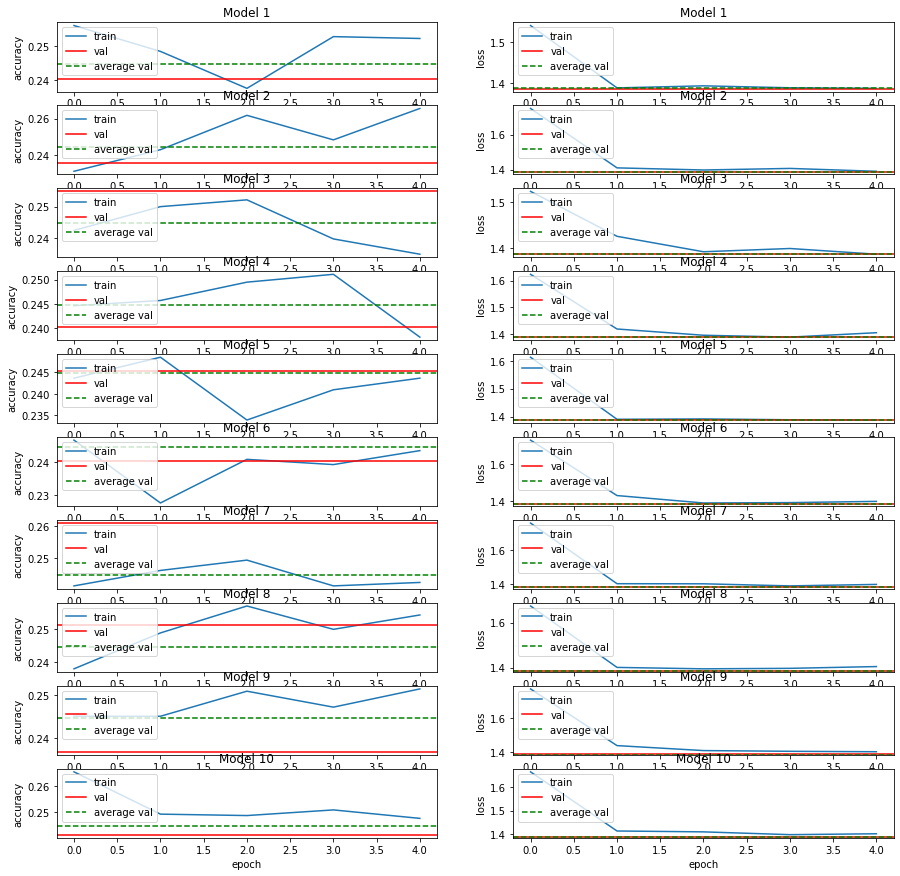

In [12]:
fig, axs = plt.subplots(n_split, 2,figsize=(15,15))

for i in range(n_split):
  axs[i][0].plot(history[i].history['accuracy'])
  axs[i][0].axhline(eval[i][1], color='r')
  axs[i][0].axhline( np.average([x[1] for x in eval]), color='g', linestyle='--')
  axs[i][0].set(title = 'Model ' + str(i+1), ylabel = 'accuracy', xlabel = 'epoch')
  axs[i][0].legend(['train', 'val', 'average val'], loc='upper left')
  axs[i][1].plot(history[i].history['loss'])
  axs[i][1].axhline(eval[i][0], color='r')
  axs[i][1].axhline(np.average([x[0] for x in eval]), color='g', linestyle='--')
  axs[i][1].set(title = 'Model ' + str(i+1), ylabel = 'loss', xlabel = 'epoch')
  axs[i][1].legend(['train', 'val', 'average val'], loc='upper left')

In [3]:
data = pd.read_csv('dataset/preprocessed/channel_pca98_df_flat_42x640')
label = pd.read_csv('dataset/preprocessed/label')


In [4]:
X = np.array(data)
Y = np.array(label)
X = X[:, 1:].reshape(2076, 42, 640, 1)
Y = Y[:, 1:]

In [20]:
#from tensorflow import keras
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, Activation, BatchNormalization, MaxPool2D, AveragePooling2D
class Conv(tf.keras.models.Model):
    def __init__(self):
        """
        init: constructor of model
        call: performs forward pass of model
        """
        super(Conv, self).__init__()

        self.layer_list = [
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding = 'same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2,2)),
            #tf.keras.layers.Conv2D(filters=32, kernel_size=(2,2), padding = 'same'),
            #tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Dropout(0.8),
            tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding = 'same'),
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Conv2D(filters=16, kernel_size=(2,2), padding = 'same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((1,1)),
            tf.keras.layers.Dropout(0.8),
            #tf.keras.layers.Conv2D(filters=16, kernel_size=(1,1), padding = 'same'),
            #tf.keras.layers.MaxPooling2D((1,1)),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(4, activation='softmax')
        ]

    @tf.function
    def call(self, inputs) -> tf.Tensor:
        """ Computes a forward step with the given data
        Parameters
        ----------
        inputs : tf.Tensor
            the input for the model
        Returns
        ----------
        x : tf.Tensor
            the output of the model
        """
        x = inputs
        for layer in self.layer_list:
            x = layer(x)
        return x

In [21]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [23]:
n_split = 10

In [24]:
history = []
eval = []
cvscores = []
i=1
for train_index,test_index in StratifiedKFold(n_split, shuffle = True, random_state=5).split(X, Y):
    print('START SPLIT', i)
    x_train,x_test= X[train_index],X[test_index]
    y_train,y_test= Y[train_index],Y[test_index]

    tf.keras.backend.clear_session()
    model = Conv()
    model.compile(loss = 'sparse_categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )
    temp = model.fit(x_train, y_train, batch_size= 10, epochs= 10, verbose = 0, validation_data = (x_test, y_test))
    history.append(temp)
    score = model.evaluate(x_test,y_test, verbose = 0)
    eval.append(score)
    cvscores.append(score[1]*100)
    print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
    i+=1
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

START SPLIT 1
accuracy: 16.83%
START SPLIT 2
accuracy: 22.12%
START SPLIT 3
accuracy: 27.88%
START SPLIT 4


ResourceExhaustedError: Graph execution error:

Detected at node 'dropout/dropout/GreaterEqual' defined at (most recent call last):
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2854, in run_cell
      result = self._run_cell(
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2900, in _run_cell
      return runner(coro)
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3098, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3301, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3361, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\fkock\AppData\Local\Temp\ipykernel_14232\4108915372.py", line 13, in <cell line: 5>
      temp = model.fit(x_train, y_train, batch_size= 10, epochs= 10, verbose = 0, validation_data = (x_test, y_test))
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\fkock\AppData\Local\Temp\ipykernel_14232\2294381554.py", line 45, in call
      for layer in self.layer_list:
    File "C:\Users\fkock\AppData\Local\Temp\ipykernel_14232\2294381554.py", line 46, in call
      x = layer(x)
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\keras\layers\core\dropout.py", line 111, in call
      output = control_flow_util.smart_cond(training, dropped_inputs,
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\keras\utils\control_flow_util.py", line 105, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\keras\layers\core\dropout.py", line 108, in dropped_inputs
      return self._random_generator.dropout(
    File "C:\Users\fkock\miniconda3\envs\tf_isd_gpu\lib\site-packages\keras\backend.py", line 1940, in dropout
      return tf.nn.dropout(inputs, rate=rate, noise_shape=noise_shape,
Node: 'dropout/dropout/GreaterEqual'
failed to allocate memory
	 [[{{node dropout/dropout/GreaterEqual}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_152358]

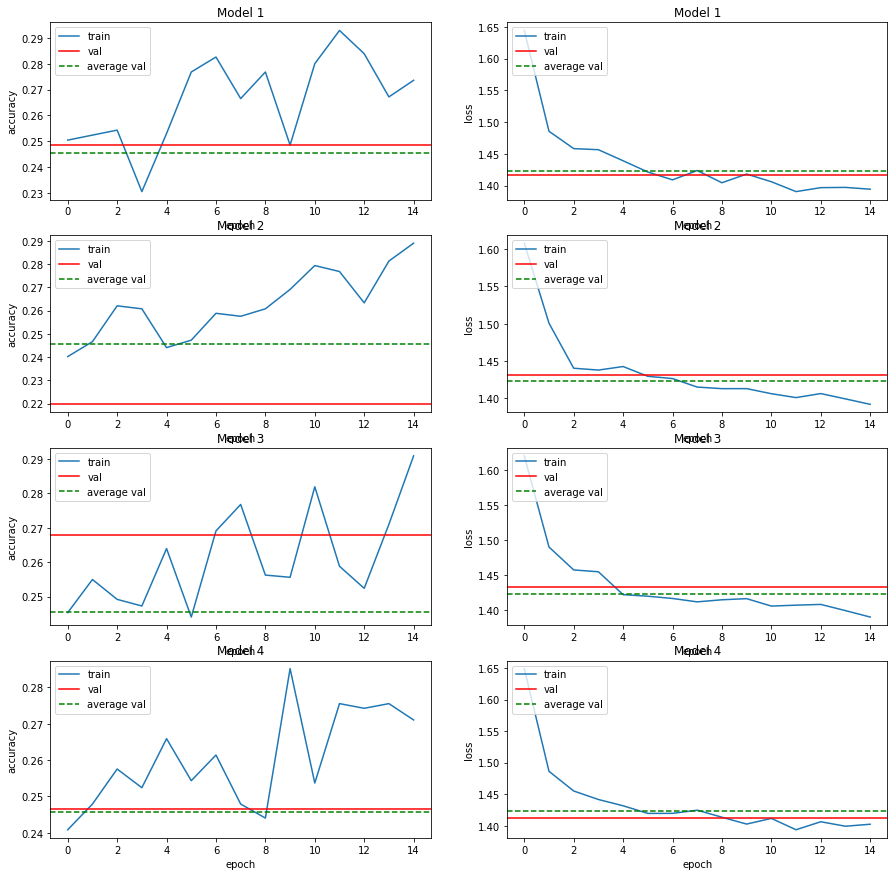

In [11]:
fig, axs = plt.subplots(n_split, 2,figsize=(15,15))

for i in range(n_split):
  axs[i][0].plot(history[i].history['accuracy'])
  axs[i][0].axhline(eval[i][1], color='r')
  axs[i][0].axhline( np.average([x[1] for x in eval]), color='g', linestyle='--')
  axs[i][0].set(title = 'Model ' + str(i+1), ylabel = 'accuracy', xlabel = 'epoch')
  axs[i][0].legend(['train', 'val', 'average val'], loc='upper left')
  axs[i][1].plot(history[i].history['loss'])
  axs[i][1].axhline(eval[i][0], color='r')
  axs[i][1].axhline(np.average([x[0] for x in eval]), color='g', linestyle='--')
  axs[i][1].set(title = 'Model ' + str(i+1), ylabel = 'loss', xlabel = 'epoch')
  axs[i][1].legend(['train', 'val', 'average val'], loc='upper left')

In [12]:
print('Average eval Loss:', np.average([x[0] for x in eval]))
print('Average eval Acc:', np.average([x[1] for x in eval]))

Average eval Loss: 1.4236087501049042
Average eval Acc: 0.24566474184393883
